In [1]:
from pathlib import Path
import pandas as pd
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
def bout_detection_v2(speed, timethresh, speedthresh):
    """
    Detects bouts in a given speed time series based on speed thresholds and time thresholds.

    Parameters:
        - speed (numpy.ndarray): Array of speed values over time.
        - timethresh (int): Minimum duration (in number of time points) for a bout to be considered valid.
        - speedthresh (float): Speed threshold to define active states (e.g., when an animal is moving).

    Returns:
        - q (numpy.ndarray): A binary array indicating the wake state (1) and sleep state (0) over time.
    """
    
    # Handling NaN values with linear interpolation
    mask = ~np.isnan(speed)
    speed_interp = np.interp(np.arange(len(speed)), np.arange(len(speed))[mask], speed[mask])
    normspeed = savgol_filter(speed_interp, 20, 0)  # Applying Savitzky-Golay filter with window size 40

    # Adjust first and last elements to avoid edge artifacts
    normspeed[0] = normspeed[0] # Adjusting the first element to avoid edge artifacts
    normspeed[-1] = normspeed[-2]  # Adjusting the last element to avoid edge artifacts

    # Normalize the smoothed speed between 0 and 1
    normspeednosmooth = (normspeed - np.min(normspeed)) / (np.max(normspeed) - np.min(normspeed))
    normspeed = normspeednosmooth

    # Initialize the output array `q` with zeros (indicating sleep state by default)
    q = np.zeros_like(normspeed)

    # Set values of `q` to 1 based on speed threshold (indicating wake state)
    q[normspeed >= speedthresh] = 1

    changed = True # Flag to track changes in `q`

    while changed:
        # Store the current state of `q` for comparison
        previous_q = q.copy()
        
        # Detect bout starts and ends based on transitions in `q` from 1 to 0 or 0 to 1
        boutstarts = np.where((q[:-1] == 1) & (q[1:] == 0))[0] + 1
        boutends = np.where((q[:-1] == 0) & (q[1:] == 1))[0] +1

        # Adjust bout starts and ends if the first or last element of `q` is 0
        if q[0] == 0:
            boutstarts = np.insert(boutstarts, 0, 1)
        if q[len(q)-1 ] == 0:
            boutends =  np.append(boutends, len(q) - 1)

        # Iterate over each bout (start, end) pair
        for start, end in zip(boutstarts, boutends):
            boutlength = end - start
            # If the bout is shorter than the minimum duration, mark it as wake time
            if boutlength < timethresh:
                q[start:end + 1] = 1  # Mark as wake time (1)

            # If bout is longer than time threshold, check the state before the bout
            if start > timethresh:
                before_sleep = np.sum(q[start-timethresh:start])
                before_sleep_speed = np.nanmean(normspeed[start-timethresh:start])
                                      
                if before_sleep != timethresh: # If there is enough data before the bout
                    # Update the state before the bout based on speed threshold
                    if before_sleep_speed < speedthresh:
                        q[start-timethresh:start] = 0 # Mark as sleep time (0)
                    if before_sleep_speed > speedthresh:
                        q[start-timethresh:start] = 1  # Mark as wake time (1)

       
                
        # Check if any changes were made to `q`
        changed = not np.array_equal(previous_q, q)



    return normspeed, q, boutstarts, boutends 

def apply_bout_detection(group, timethresh, speedthresh):
    """
    Applies the bout detection algorithm to a group of worm data, detects bouts based on speed, and
    updates the group DataFrame with binary state data.

    Parameters:
        - group (pd.DataFrame): A pandas DataFrame containing worm data, including speed.
        - timethresh (int): Minimum duration (in number of time points) for a bout to be considered valid.
        - speedthresh (float): Speed threshold to define active states (e.g., when the worm is moving).

    Returns:
        - group (pd.DataFrame): The input DataFrame updated with binary state (`binary_table`) and normalized speed (`norm_speed`).
        - summary (pd.DataFrame): A summary DataFrame containing information about each worm's bouts.
    """
    # Convert the 'speed' column from the group to a numpy array for further processing
    speed = group['speed'].to_numpy()

    # Apply the bout detection algorithm (assuming it returns normed speed, binary state q, and bout starts/ends)
    normspeed, q, boutstarts, boutends = bout_detection_v2(speed, timethresh, speedthresh)
    
    # Update group DataFrame with binary_table
    group['binary_table'] = q # Add the binary wake/sleep state to the DataFrame
    group['norm_speed'] = normspeed # Add the normalized speed values to the DataFrame
    # Create a summary DataFrame with n_worm, boutstarts, and boutends
    
    # Create a summary DataFrame containing relevant bout information for this worm
    summary = pd.DataFrame({
        'n_worm': [group['n_worm'].iloc[0]],  # Assume 'n_worm' is consistent within the group
        'replicate': [group['replicate'].iloc[0]],
        'boutstarts': [boutstarts],
        'boutends': [boutends]
    })

    # Return the updated group and the summary DataFrame
    return group, summary

In [ ]:
# Define the folder path where the CSV file is located
folder_path = r"S:\microscopy\Calcium imaging\24.02.23-29 srx-9_FLP\analysis_paper\bout_analysis"
# Define the base name for the file
file_name = 'intensity_and_speed_immobiliy_df_'
# Define the strain name (e.g., "3451") to create a specific file name
strain_name = '3451'
# Construct the full file name by combining the base file name with the strain name
strain_file_name =  file_name + strain_name + ".csv"
# Read the CSV file into a pandas DataFrame using the full file path
data_df = pd.read_csv(os.path.join(folder_path, strain_file_name))
# Display the contents of the DataFrame
data_df

In [ ]:
#run if necessary
data_df['centroid_x'] = pd.to_numeric(data_df['centroid_x'], errors='coerce')
data_df['centroid_y'] = pd.to_numeric(data_df['centroid_y'], errors='coerce')

# Drop rows with NaN values in 'centroid_x' or 'centroid_y'
data_df = data_df.dropna(subset=['centroid_x', 'centroid_y'])

# Group by 'n_worm' and calculate distances within each group
def calculate_distance(group):
    x_squared_diff = (group['centroid_x'] - group['centroid_x'].shift()) ** 2
    y_squared_diff = (group['centroid_y'] - group['centroid_y'].shift()) ** 2
    group['distance'] = (x_squared_diff + y_squared_diff) ** 0.5
    return group

speed_coefficient = 1.09 * 0.17

# Calculate the speed by multiplying the distance by the speed coefficient
data_df['speed'] = data_df['distance'] * speed_coefficient

# Calculate the normalized intensity by dividing intensity_gcamp by intensity_mKate
data_df['normalised_intensity'] = data_df['intensity_gcamp'] / data_df['intensity_mKate']
data_df

In [32]:
# Set the time coefficient based on frame rate (1/6 frames per second)
time_coefficient = 1/6 #frame/s
# Define the time threshold (e.g., 120 frames converted to seconds)
time_threshold = int(120 * time_coefficient) # Replace with your desired time threshold
# Set the speed threshold for bout detection
speed_threshold = 0.20  # Replace with your desired speed threshold

# Initialize lists to store updated data and bout data
updated_data = []
bouts_data = []

# Group the original data by 'replicate' and 'n_worm'
grouped_q = data_df.groupby(['replicate', 'n_worm'])


# Iterate through each group (representing each worm and replicate)
for name, group in grouped_q:
    # Apply the bout detection function to the current group
    q, bouts = apply_bout_detection(group, time_threshold, speed_threshold)

    # Append the updated group data and bout information to respective lists
    updated_data.append(q)
    bouts_data.append(bouts)

# Concatenate the updated groups back into a single DataFrame
updated_data_df = pd.concat(updated_data)

# Concatenate the summary DataFrames
bouts_df = pd.concat(bouts_data, ignore_index=True)


In [ ]:
updated_data_df

In [ ]:
bouts_df

In [35]:
# Specify the filename for saving the DataFrame to a CSV file
file_to_save = 'grouped_intensity_and_speed_df_' + strain_name + '.csv'

# Create the full path for saving the CSV file
saving_path = os.path.join(folder_path, file_to_save)

# Save the DataFrame to a CSV file at the specified path
updated_data_df.to_csv(saving_path, index=False)

In [ ]:
data_rows = []
bout_data = []
bout_thresh = 20 #frames

grouped_replicates_bouts = bouts_df.groupby(['replicate', 'n_worm'])
#grouped_q = updated_data_df.groupby(['replicate', 'n_worm'])

# Define some constants for bout detection and analysis
time_before_bs = 150 # Time before bout start (frames)
time_after_bs = 350 # Time after bout end (frames)
current_n_worm = None
total_time = time_before_bs + time_after_bs # Total time around bout

# Create empty arrays to store aligned data for sleep, speed, and intensity
aligned_sleep_matrix = np.empty((0, (total_time)))
aligned_peaks_matrix = np.empty((0, (total_time)))
aligned_speed_matrix = np.empty((0, (total_time)))

aligned_peaks_matrix_of_worms = []
aligned_speed_matrix_of_worms = []
aligned_sleep_matrix_of_worms = []

for (replicate, n_worm), group in grouped_replicates_bouts:
    bstarts = group['boutstarts'].tolist()[0] # Bout start indices
    bends = group['boutends'].tolist()[0] # Bout end indices

    
    # Filter data for the current worm and replicate
    relevant_data = updated_data_df[(updated_data_df['replicate'] == replicate) & (updated_data_df['n_worm'] == n_worm)]
    relevant_data = relevant_data.reset_index(drop=True)
    
    # Interpolate missing values in 'speed' and 'normalised_intensity'
    relevant_data['speed'] = relevant_data['speed'].interpolate(method='linear', limit_direction='both')
    relevant_data['normalised_intensity'] = relevant_data['normalised_intensity'].interpolate(method='linear', limit_direction='both')
    
    # Apply Savitzky-Golay filter to smooth speed and intensity
    relevant_data['smooth_speed'] = savgol_filter(relevant_data['speed'], window_length=20, polyorder=0, mode='mirror')
    relevant_data['smooth_intensity'] = savgol_filter(relevant_data['normalised_intensity'], window_length=20, polyorder=0, mode='mirror')

    # If the worm ID changes, store mean values of previous worm's data
    if current_n_worm is not None and n_worm != current_n_worm:
        
        # Calculate the mean for the previous worm and append it
        worm_mean_sleep = np.nanmean(aligned_sleep_matrix, axis=0)
        aligned_sleep_matrix_of_worms.append(worm_mean_sleep)
        aligned_sleep_matrix = np.empty((0, (total_time)))  # Reset for the new worm


        worm_mean_speed = np.nanmean(aligned_speed_matrix, axis=0)
        aligned_speed_matrix_of_worms.append(worm_mean_speed)
        aligned_speed_matrix = np.empty((0, (total_time))) # Reset for the new worm

        worm_mean_peaks = np.nanmean(aligned_peaks_matrix, axis=0)
        aligned_peaks_matrix_of_worms.append(worm_mean_peaks)
        aligned_peaks_matrix = np.empty((0, (total_time))) # Reset for the new worm

        # Append worm data to rows
        for j, (intensity, speed, sleep) in enumerate(zip(worm_mean_peaks, worm_mean_speed, worm_mean_sleep)):
            data_rows.append({'n_worm': current_n_worm, 'replicate': replicate, 'time': j, 'intensity': intensity, 'speed':speed, 'sleep':(1-sleep), 'strain': strain_name})



        
        
    current_n_worm = n_worm  # Update the current worm
    #print(replicate, n_worm)

    # For each bout, extract data within the specified range and append to the matrices
    for bs, be in zip(bstarts, bends):
        bout_length = be - bs
        x_start = bs-time_before_bs
        x_end = bs + time_after_bs
        
        if bout_length >= bout_thresh:
            bout_data.append({'strain': strain_name, 'n_worm' : n_worm, 'replicate': replicate, 'bout_length': ((bout_length +1)/time_coefficient)/60 })

             # Handle out-of-bound indices for the beginning or end of the bout
            if x_start < 0: # If bout starts before the data
                if bs == 1:
                    # Fill the start with NaNs and align data
                    original_sleep = np.array(relevant_data.loc[:x_end-2, 'binary_table'].values)
                    sleep = (np.append(np.repeat(np.nan, (1+abs(x_start))), original_sleep)).reshape(1,total_time)
                    aligned_sleep_matrix =  np.append(aligned_sleep_matrix, sleep, axis = 0)
                    
                    original_speed = np.array(relevant_data.loc[:x_end-2, 'smooth_speed'].values)
                    speed = (np.append(np.repeat(np.nan, (1+abs(x_start))), original_speed)).reshape(1,total_time)
                    aligned_speed_matrix =  np.append(aligned_speed_matrix, speed, axis = 0)

                    original_peak = np.array(relevant_data.loc[:x_end-2, 'smooth_intensity'].values)
                    peak = (np.append(np.repeat(np.nan, (1+abs(x_start))), original_peak)).reshape(1,total_time)
                    aligned_peaks_matrix =  np.append(aligned_peaks_matrix, peak, axis = 0)
                    
                    

                else: 
                     # Extract the binary_table values for the given range and current replicate/n_worm
                    original_sleep = np.array(relevant_data.loc[:x_end-1, 'binary_table'].values)
                    sleep = (np.append(np.repeat(np.nan, abs(x_start)), original_sleep)).reshape(1,total_time)
                    aligned_sleep_matrix =  np.append(aligned_sleep_matrix, sleep, axis = 0)
                    
                    original_speed = np.array(relevant_data.loc[:x_end-1, 'smooth_speed'].values)
                    speed = (np.append(np.repeat(np.nan, abs(x_start)), original_speed)).reshape(1,total_time)
                    aligned_speed_matrix =  np.append(aligned_speed_matrix, speed, axis = 0)

                    original_peak = np.array(relevant_data.loc[:x_end-1, 'smooth_intensity'].values)
                    peak = (np.append(np.repeat(np.nan, abs(x_start)), original_peak)).reshape(1,total_time)
                    aligned_peaks_matrix =  np.append(aligned_peaks_matrix, peak, axis = 0)
                    

            elif x_end > relevant_data.index[-1]: # If bout ends after the data
                original_sleep = np.array(relevant_data.loc[x_start:, 'binary_table'].values)
                sleep = (np.append(original_sleep, np.repeat(np.nan, x_end - relevant_data.index[-1]-1))).reshape(1,total_time)
                aligned_sleep_matrix =  np.append(aligned_sleep_matrix, sleep, axis = 0)
                
                original_speed = np.array(relevant_data.loc[x_start:, 'smooth_speed'].values)
                speed = (np.append(original_speed, np.repeat(np.nan, x_end - relevant_data.index[-1]-1))).reshape(1,total_time)
                aligned_speed_matrix =  np.append(aligned_speed_matrix, speed, axis = 0)

                original_peak = np.array(relevant_data.loc[x_start:, 'smooth_intensity'].values)
                peak = (np.append(original_peak, np.repeat(np.nan, x_end - relevant_data.index[-1]-1))).reshape(1,total_time)
                aligned_peaks_matrix =  np.append(aligned_peaks_matrix, peak, axis = 0)
                
            else: # If bout fits within the data bounds
                original_sleep = np.array(relevant_data.loc[x_start:x_end-1, 'binary_table'].values)
                sleep = original_sleep.reshape(1,total_time)
                aligned_sleep_matrix =  np.append(aligned_sleep_matrix, sleep, axis = 0)
                
                original_speed = np.array(relevant_data.loc[x_start:x_end-1, 'smooth_speed'].values)
                speed = original_speed.reshape(1,total_time)
                aligned_speed_matrix =  np.append(aligned_speed_matrix, speed, axis = 0)

                original_peak = np.array(relevant_data.loc[x_start:x_end-1, 'smooth_intensity'].values)
                peak = original_peak.reshape(1,total_time)
                aligned_peaks_matrix =  np.append(aligned_peaks_matrix, peak, axis = 0)
            

# Handle the last worm (after exiting the loop)
if aligned_sleep_matrix.size > 0:
    worm_mean_sleep = np.nanmean(aligned_sleep_matrix, axis=0)
    aligned_sleep_matrix_of_worms.append(worm_mean_sleep)
    print(worm_mean_sleep[149], current_n_worm)

if aligned_speed_matrix.size > 0:
    worm_mean_speed = np.nanmean(aligned_speed_matrix, axis=0)
    aligned_speed_matrix_of_worms.append(worm_mean_speed)

if aligned_peaks_matrix.size > 0:
    worm_mean_peaks = np.nanmean(aligned_peaks_matrix, axis=0)
    aligned_peaks_matrix_of_worms.append(worm_mean_peaks)

# Store the final data for the last worm
for j, (intensity, speed, sleep) in enumerate(zip(worm_mean_peaks, worm_mean_speed, worm_mean_sleep)):
    data_rows.append({'n_worm': current_n_worm, 'replicate': replicate, 'time': j, 'intensity': intensity, 'speed':speed, 'sleep':(1-sleep), 'strain': strain_name})

# Create DataFrame with all the processed data
worm_bout_df = pd.DataFrame(data_rows)

# Specify the filename for saving
worm_bout_to_save = f'{strain_name}_each_worm_bout_{time_after_bs}_min.csv'

# Create the full path for saving the CSV file
worm_bout_to_save_path = os.path.join(folder_path, worm_bout_to_save)

# Save the DataFrame to a CSV file at the specified path
worm_bout_df.to_csv(worm_bout_to_save_path, index=False)

worm_bout_df


In [ ]:
# Convert the list of bout data into a DataFrame
bout_data_df = pd.DataFrame(bout_data) 

# Define the total movie length in minutes
movie_length = 300 #minutes
# Group the bout data by replicate and worm number
bout_grouped = bout_data_df.groupby(['replicate','n_worm'])


average_bout_lengths = bout_grouped['bout_length'].mean() # Compute the average bout length per worm
sleep_fraction = bout_grouped['bout_length'].sum() / movie_length # Compute the sleep fraction (total sleep time divided by movie length)
bout_frequency = bout_grouped['bout_length'].count() / (movie_length/60) # Compute the bout frequency (number of bouts per hour)





# Create a DataFrame to store calculated sleep metrics
result_data = {
    'replicate': [key[0] for key in bout_grouped.groups.keys()],
    'n_worm': [key[1] for key in bout_grouped.groups.keys()],
    'strain': strain_name,
    'average_bout_length': average_bout_lengths.values,
    'sleep_fraction': sleep_fraction.values,
    'bout_frequency': bout_frequency.values

}
# Convert the dictionary to a DataFrame
sleep_data_df = pd.DataFrame(result_data)


# Specify the filename for saving the DataFrame to a CSV file
sleep_to_save = f'sleep_data_{strain_name}.csv'

# Create the full path for saving the CSV file
saving_path_sleep = os.path.join(folder_path, sleep_to_save)

# Save the DataFrame to a CSV file at the specified path
sleep_data_df.to_csv(saving_path_sleep, index=False)  
sleep_data_df

In [38]:
import math
# Count the number of valid (non-NaN) values for each time point across all worms
valid_counts = np.sum(~np.isnan(aligned_sleep_matrix_of_worms), axis=0) 

# Compute the mean of aligned peaks (normalized intensity) across worms
aligned_peaks = np.nanmean(aligned_peaks_matrix_of_worms, axis = 0)
# Compute the standard error of the mean (SEM) for peaks
error_peaks = np.nanstd(aligned_peaks_matrix_of_worms, axis=0)/np.sqrt(valid_counts)

# Compute the mean of aligned speed values across worms
aligned_speed = np.nanmean(aligned_speed_matrix_of_worms, axis = 0)
# Compute the standard error of the mean (SEM) for speed
error_speed = np.nanstd(aligned_speed_matrix_of_worms, axis=0)/np.sqrt(valid_counts)

# Compute the fraction of time spent sleeping by taking 1 minus the fraction of active states
aligned_sleep = 1 - np.nansum(aligned_sleep_matrix_of_worms, axis=0)/ valid_counts

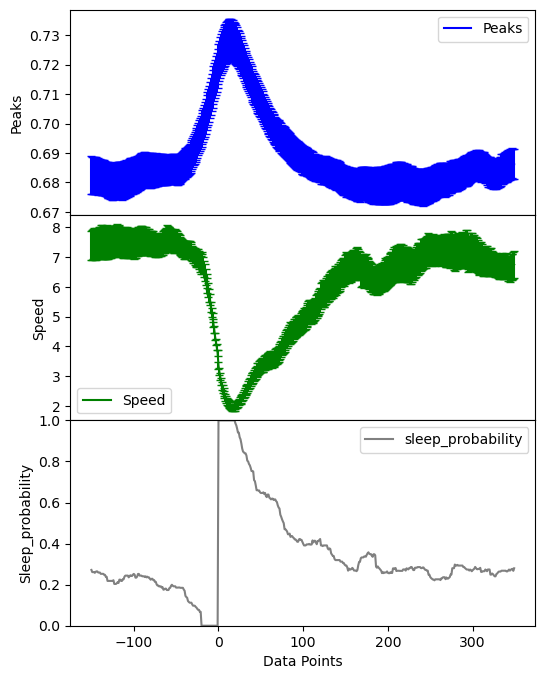

In [40]:
import matplotlib.pyplot as plt


# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8), sharex=True)

# Generate x-axis values
x_values = np.arange(-time_before_bs, time_after_bs)

# Plot aligned_peaks
ax1.plot(x_values, aligned_peaks, color='blue', label='Peaks')
ax1.errorbar(
    x=x_values,
    y=aligned_peaks,
    yerr=error_peaks,
    color='blue',
    capsize=3,
    fmt='none'
)
ax1.set_ylabel('Peaks')
ax1.legend()

# Plot aligned_speed
ax2.plot(x_values, aligned_speed, color='green', label='Speed')
ax2.errorbar(
    x=x_values,
    y=aligned_speed,
    yerr=error_speed,
    color='green',
    capsize=3,
    fmt='none'
)
ax2.set_xlabel('Data Points')
ax2.set_ylabel('Speed')
ax2.legend()

# Plot aligned_sleep
ax3.plot(x_values, aligned_sleep, color='gray', label='sleep_probability')
ax3.errorbar(
    x=x_values,
    y=aligned_sleep,
    capsize=3,
    fmt='none'
)
ax3.set_ylim(0, 1)
ax3.set_xlabel('Data Points')
ax3.set_ylabel('Sleep_probability')
ax3.legend()

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0)

# Show the plot
plt.show()

In [41]:
# Combine the computed statistical data into a dictionary
data = {
    'Mean Vector Speed': aligned_speed,      # Average speed across worms at each time point
    'Error Speed': error_speed,              # Standard error of speed
    'Mean Vector Intensity': aligned_peaks,  # Average fluorescence intensity across worms at each time point
    'Error Intensity': error_peaks,          # Standard error of fluorescence intensity
    'Sleep probability': aligned_sleep       # Probability of sleep at each time point
}

# Create a pandas DataFrame from the data dictionary
saving_df = pd.DataFrame(data)

# Specify the filename for saving the DataFrame to a CSV file[]
file_to_save = f'smooth_{strain_name}_bout_alignment_{time_after_bs}_frame.csv'

# Create the full path for saving the CSV file
saving_path = os.path.join(folder_path, file_to_save)

# Save the DataFrame to a CSV file at the specified path
saving_df.to_csv(saving_path)